In [1]:
import crocoddyl
import mujoco
import mujoco.viewer
import mim_solvers
import numpy as np
import matplotlib.pyplot as plt
import hppfcl
import time
from os.path import dirname, join, abspath
np.set_printoptions(precision=4, linewidth=180)

import pin_utils, mpc_utils
from Kuka_utils import *
from Kuka_model import *
from Kuka_Mujoco_utils import *
from IRL_solver import IRL_Crocoddyl
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer

from mim_robots.pybullet.env import BulletEnvWithGround
from mim_robots.robot_loader import load_bullet_wrapper, load_mujoco_model, get_robot_list, load_pinocchio_wrapper
from mim_robots.robot_list import MiM_Robots
from numpy.linalg import norm, solve
from scipy.spatial.transform import Rotation as R
from scipy.optimize import minimize
from scipy.optimize import Bounds


pybullet build time: Nov 28 2023 23:45:17


In [2]:
%run -i 'init.py'

In [3]:
obs_set = obstacle_set()
obs_set.add_obs(np.array([0.65, -0.05, 0.7]), l = 0.05, col_r = 0.15)
obs_set.add_obs(np.array([0.65, -0.15, 0.45]), l = 0.1, col_r = 0.15)
obs_set.add_obs(np.array([0.65, -0.25, 0.7]), l = 0.1, col_r = 0.15)
obs_num = obs_set.obs_num

In [4]:
# endeff frame translation goal
endeff_frame_id = pin_model.getFrameId("contact")
endeff_joint_id = pin_model.getJointId("contact")
# endeff_translation = pin_data.oMf[endeff_frame_id].translation.copy()
endeff_translation = np.array([0.4,  -0.5,  0.35])

In [5]:
w_run = {
    'translation': .1,
    'xReg': 0.1,
    'uReg': 0.0001
}

w_term = {
    'translation': 10,
    'xReg': 0.1
}

w_run_bad = {
    'translation': .0,
    'xReg': 0.1,
    'uReg': 0.0001
}

w_term_bad = {
    'translation': 0.1,
    'xReg': 0.1
}

# w_run_bad = {
#     'xReg': 0.01,
#     'uReg': 0.0,
#     'translation': .0
# }

# w_term_bad = {
#     'xReg': 0.0,
#     'translation': .0    
# }

c=0
for _ in range(obs_set.obs_num): # Adding Obstacle weights
    w_run['collision'+str(c)] = 1000
    w_term['collision'+str(c)] = 1000
    w_run_bad['collision'+str(c)] = 0
    w_term_bad['collision'+str(c)] = 0
    c+=1

w_run = dict(sorted(w_run.items()))
w_term = dict(sorted(w_term.items()))
w_run_bad = dict(sorted(w_run_bad.items()))
w_term_bad = dict(sorted(w_term_bad.items()))

w_run, w_term = normalize_w(w_run, w_term)
w_run_bad, w_term_bad = normalize_w(w_run_bad, w_term_bad)

In [6]:
dt = 1e-2
T = 150

solver, runningDatas, terminalData = init_robot(robot_simulator, q0, v0, obs_set, endeff_translation, w_run, w_term, dt, T)

Keys_run = solver.problem.runningDatas[0].differential.costs.costs.todict().keys()
Keys_term = solver.problem.terminalData.differential.costs.costs.todict().keys()
nr_run = len(Keys_run); nr_term = len(Keys_term); nr = nr_run + nr_term

xs_init = [x0 for i in range(T+1)]
us_init = solver.problem.quasiStatic(xs_init[:-1])

/home/sarmad/machines-in-motion/my_git/IRL_Kuka/Kuka_utils.py:29: UserWarning: Deprecated member. Use Frame.parentJoint instead.
  m.frames[pin_model.getFrameId("universe")].parent,
/home/sarmad/machines-in-motion/my_git/IRL_Kuka/Kuka_utils.py:27: UserWarning: This function has been marked as deprecated and will be removed in a future release.
  obsObj = pin.GeometryObject("obstacle"+str(num_obs),


In [7]:
# Solve 
update_solver_weights(solver, T, w_run, w_term)
solver.termination_tolerance = 1e-4
solver.with_callbacks = False
solver.solve(xs_init, us_init, 500)
xs_opt = solver.xs.copy()
us_opt = solver.us.copy()

In [8]:
update_solver_weights(solver, T, w_run_bad, w_term_bad)
solver.termination_tolerance = 1e-4
solver.with_callbacks = False
solver.solve(xs_init, us_init, 500)
xs_nopt = solver.xs.copy()
us_nopt = solver.us.copy()

In [9]:
## IRL Args
irl_args = {
    'solver': solver,
    'w_run': w_run_bad,
    'w_term': w_term_bad,
    'type': 'autoreg', 'irl_iter': 1, 'sqp_iter': 1, 'next_traj': 'optimal', 'lr': 1.0,
    'dt': dt,
    'line_search_steps': 10, 'line_search_base': 'both',
    'use_bad': True, 'xs_nopt': xs_nopt, 'us_nopt': us_nopt,
    'normalize': False,
    'K_set': 3,
    'N_samples': T,
    'use_best': False,
    'Lambda': 0.0,
    'KL_tol': -10.0,
    'max_iter': 300, 'min_iter': 15,
    'compare_desired': True, 'des_run': w_run, 'des_term': w_term,
    'verbose': True
}

In [10]:
if 'IRL' in globals():
    del(IRL)
IRL = IRL_Crocoddyl(xs_opt, us_opt, irl_args)
IRL.print_info()

IRL Parameters:
Initial Running Weight:  {'collision0': 0.0, 'collision1': 0.0, 'collision2': 0.0, 'translation': 0.0, 'uReg': 0.001, 'xReg': 1.0}
Initial Terminal Weight:  {'collision0': 0.0, 'collision1': 0.0, 'collision2': 0.0, 'translation': 1.0, 'xReg': 1.0}
Type:  autoreg
Set Size:  3
Sample Size:  150
Lambda:  0.0
SQP Iterations:  1
IRL Max Iteration:  300
Sample Time:  0.01


In [11]:
begin_time = time.time()
IRL.solve_irl()
end_time = time.time()
last_x = IRL.last_traj[0]; last_u = IRL.last_traj[1]
best_x = IRL.best_traj[0]; best_u = IRL.best_traj[1]
print('Duration: ', end_time - begin_time)

-- iter -- KL_div ---- KL_des ---- Opt Div --- Cost Diff --- Fcn Val ---- Step ---
1.0288828153988316 16154.74322346056
1.002206309116976 31575.220392070863
0.9993712197801903 31923.930396723696
||   0  || 0.000004 || 2.423204 || 0.999371 || 23618.817379 || 16778.203275 || 0.062
1.029066067941752 16112.612665538325
1.0028517865906055 31489.34703579655
1.0001324310075406 31834.502572995647
0.9995557074331771 31902.519007901315
0.9994169915528909 31918.633540946605
0.9993826410399568 31922.609636388373
0.9993740737430209 31923.60042178378
0.9993719331864391 31923.847916424136
0.9993713981264746 31923.90977748835
0.9993712643664315 31923.925241967314
||   1  || 2.584068 || 1.172097 || 1.029066 || 42.623074 || 8.632695 || 1.000
||   2  || 0.440255 || 0.000008 || 0.008788 || 0.000000 || 199.739453 || 1.000
||   3  || 0.000000 || 0.000008 || 0.008761 || 0.000000 || 201.766323 || 0.000
||   4  || 0.000000 || 0.000000 || 0.008787 || 0.000000 || 203.798778 || 1.000
||   5  || 0.000000 || 0.0000

In [12]:
IRL.opt_div

[1.0,
 0.9993712197801903,
 1.029066067941752,
 0.008787780769866827,
 0.008761099253444732,
 0.008786904258798732,
 0.007043063263538317,
 0.006922490805916294]

In [13]:
# w_irl_run, w_irl_term = IRL.vector_to_dict(IRL.last_w[0], IRL.last_w[1])
# print('Last Cost: ', IRL.get_traj_costs(IRL.phis_set[-1], IRL.last_w[0], IRL.last_w[1])[0])
# print('Best Cost: ', IRL.get_traj_costs(IRL.phis_set[IRL.best_ind], IRL.best_w[0], IRL.best_w[1])[0])

In [14]:
cost_set = []
for i in range(len(IRL.Xs)-1):
    dc = IRL.get_traj_costs(IRL.phis_set[i], IRL.ws[i][0], IRL.ws[i][1])[0] - IRL.get_traj_costs(IRL.phis_opt, IRL.ws[i][0], IRL.ws[i][1])[0]
    # print('Cost Diff: ', dc)
    cost_set.append(dc**2)
# plt.semilogy(cost_set)
addr = np.argmin(np.array(cost_set[1:]))
print('iteration: ', addr)
cost_set[addr]

iteration:  6


9.382102408554117e-08

In [15]:
addr = -1

In [16]:
w_chosen_run = IRL.ws[addr][0]; w_chosen_term = IRL.ws[addr][1]
print('Running')
for i, key in enumerate(IRL.keys_run):
    print(key, ':')
    print('Desired: {:.5f} || Initial: {:.5f} || Chosen: {:.5f}'.format(list(w_run.values())[i],
                                                                        list(w_run_bad.values())[i],
                                                                  w_chosen_run[i]))
    # print('Desired: {:.4f} || Best: {:.4f}'.format(list(w_run.values())[i],IRL.best_w[0][i]))
print()
print('Terminal')
for i, key in enumerate(IRL.keys_term):
    print(key, ':')
    print('Desired: {:.5f} || Initial: {:.5f} || Chosen: {:.5f}'.format(list(w_term.values())[i], 
                                                                        list(w_term_bad.values())[i], 
                                                                  w_chosen_term[i]))
    # print('Desired: {:.4f} || Best: {:.4f}'.format(list(w_term.values())[i], IRL.best_w[1][i]))


Running
collision0 :
Desired: 1.00000 || Initial: 0.00000 || Chosen: 0.09894
collision1 :
Desired: 1.00000 || Initial: 0.00000 || Chosen: 1.00000
collision2 :
Desired: 1.00000 || Initial: 0.00000 || Chosen: 0.13278
translation :
Desired: 0.00010 || Initial: 0.00000 || Chosen: 0.00000
uReg :
Desired: 0.00000 || Initial: 0.00100 || Chosen: 0.00000
xReg :
Desired: 0.00010 || Initial: 1.00000 || Chosen: 0.00002

Terminal
collision0 :
Desired: 1.00000 || Initial: 0.00000 || Chosen: 0.00009
collision1 :
Desired: 1.00000 || Initial: 0.00000 || Chosen: 0.00760
collision2 :
Desired: 1.00000 || Initial: 0.00000 || Chosen: 0.00404
translation :
Desired: 0.01000 || Initial: 1.00000 || Chosen: 0.16724
xReg :
Desired: 0.00010 || Initial: 1.00000 || Chosen: 0.00000


In [17]:
n = addr
# n = -1
xs = IRL.Xs[n]
us = IRL.Us[n]
viewer = init_mujoco(mj_model, mj_data, q0, np.zeros(nq), obs_set, endeff_translation)
time.sleep(4)
# for i in range(IRL.max_iter):
#     run_traj(viewer, mj_model, mj_data, pin_model, pin_data, IRL.Xs[i], IRL.Us[i], dt)
run_traj(viewer, mj_model, mj_data, pin_model, pin_data, xs, us, dt)
# run_traj(viewer, mj_model, mj_data, pin_model, pin_data, xs_opt, us_opt, dt)
# run_traj(viewer, mj_model, mj_data, pin_model, pin_data, best_x, best_u, dt)
# run_traj(viewer, mj_model, mj_data, pin_model, pin_data, last_x, last_u, dt)

In [18]:
W = np.stack([IRL.ws[i][-1] for i in range(len(IRL.ws))])

196.7480663089721
28421.57134261872
0.006922490805916294


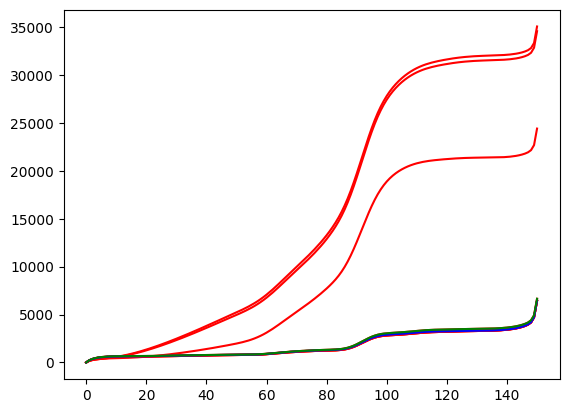

In [19]:
phi_opt, phis_opt = IRL.get_traj_features(xs_opt, us_opt)
phi_nopt, phis_nopt = IRL.get_traj_features(xs_nopt, us_nopt)

for i in range(len(IRL.Xs)):
    xs = IRL.Xs[i]
    us = IRL.Us[i]
    phi, phis = IRL.get_traj_features(xs, us)
    p = []
    o = []
    no = []
    for p_, o_, no_ in zip(phis, phis_opt, phis_nopt):
        p.append(np.linalg.norm(p_))
        o.append(np.linalg.norm(o_))
        no.append(np.linalg.norm(no_))

    plt.plot(p, color='red')
plt.plot(p, color='blue')
plt.plot(o, color='green')
# plt.plot(no)

print(np.linalg.norm(phi - phi_opt))
print(np.linalg.norm(phi_nopt - phi_opt))
print(np.linalg.norm(phi - phi_opt)/np.linalg.norm(phi_nopt - phi_opt))

In [20]:
for i in range(len(IRL.Xs)):
    xs = IRL.Xs[i]
    us = IRL.Us[i]
    phi_, phis_ = IRL.get_traj_features(xs, us)
    print(np.linalg.norm(phis_[-1] - phis_opt[-1])/np.linalg.norm(phis_nopt[-1] - phis_opt[-1]),
         np.linalg.norm(phi_ - phi_opt)/np.linalg.norm(phi_nopt - phi_opt))

0.0 0.0
1.0 1.0
0.9826078116226836 0.9826078116226836
0.6250791750808268 0.6250791750808268
0.008092643617975036 0.008092643617975036
0.008067861566057887 0.008067861566057887
0.00809163636517357 0.00809163636517357
0.007004875513817838 0.007004875513817838
0.006922490805916294 0.006922490805916294


In [24]:
IRL.solver.cost
IRL.w_run

{'collision0': 0.0989381581683892,
 'collision1': 1.0,
 'collision2': 0.1327804870522322,
 'translation': 1.2328999706620066e-08,
 'uReg': 0.0,
 'xReg': 1.5258767391002035e-05}

In [37]:
IRL.ws[2][0]

array([1.7875e-03, 0.0000e+00, 0.0000e+00, 1.0000e+00, 4.7059e-05, 4.7059e-02])

In [42]:
w_term_bad

{'collision0': 0.0,
 'collision1': 0.0,
 'collision2': 0.0,
 'translation': 1.0,
 'xReg': 1.0}

In [28]:
# _, phis = IRL.get_traj_features(IRL.Xs[-1], IRL.Us[-1])
_, phis = IRL.get_new_traj_features()
# w_run_v, w_term_v, wv = IRL.dict_to_vector()
cost, costs = IRL.get_traj_costs(phis, IRL.ws[-1][0], IRL.ws[-1][1])
print(costs[-1])
len(costs)

0.002277055705762289


151

In [43]:
n = 0
wr, wt, w = IRL.dict_to_vector()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [54]:
n = 7
IRL.vector_to_dict(IRL.ws[n][0], IRL.ws[n][1])

({'collision0': 0.0989381581683892,
  'collision1': 1.0,
  'collision2': 0.1327804870522322,
  'translation': 1.2328999706620066e-08,
  'uReg': 0.0,
  'xReg': 1.5258767391002035e-05},
 {'collision0': 9.208183905924935e-05,
  'collision1': 0.0075951272492532085,
  'collision2': 0.004040475184964824,
  'translation': 0.16724141557712846,
  'xReg': 3.856651815547267e-08})